In [1]:
# import standard packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#import sklearn pipeline & preprocessing packages
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#import imblearn packages for imbalanced data
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTETomek

#import sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


#import sklearn metrics 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc 

import warnings
warnings.simplefilter('ignore')


In [2]:
#import data set
filepath = "C:/Users/lasha/repositories/CustomerChurn_Cap2/data/interim/ready_for_modelling_Telco_Customer_Churn.csv"
churn_df = pd.read_csv(filepath, index_col = 0, usecols=range(1,54))
churn_df.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenureGroups_1 - 12,tenureGroups_13 - 24,tenureGroups_25 - 36,tenureGroups_37 - 48,tenureGroups_49 - 60,tenureGroups_61 - 72,tenureGroups_> 72
SeniorCitizen,,,,,,,,,,,,,,,,,,,,,
0,1,29.85,29.85,0,1,0,0,1,1,0,...,0,1,0,1,0,0,0,0,0,0
0,34,56.95,1889.50,0,0,1,1,0,1,0,...,0,0,1,0,0,1,0,0,0,0
0,2,53.85,108.15,1,0,1,1,0,1,0,...,0,0,1,1,0,0,0,0,0,0
0,45,42.30,1840.75,0,0,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
0,2,70.70,151.65,1,1,0,1,0,1,0,...,0,1,0,1,0,0,0,0,0,0


In [3]:
#split into train and test sets
X = churn_df.drop(columns=['Churn'])
y = churn_df['Churn']

print(X.shape, y.shape)
# split the data. I'm using random state = 30 for reproducability
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y, random_state=30)


(7032, 51) (7032,)


In [4]:
column_names = X_train.columns
print(column_names)

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Female',
       'gender_Male', 'Partner_No', 'Partner_Yes', 'Dependents_No',
       'Dependents_Yes', 'PhoneService_No', 'PhoneService_Yes',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_

In [5]:
# we need to scale the data
# instantiate the standard scaler
scaler = StandardScaler()
#fit and transform the monthly charges
X_train_scaled = scaler.fit_transform(X_train)

#convert X_train array back into a dataframe
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = column_names)

#transform test data
X_test_scaled = scaler.transform(X_test)
#convert X_test array back into a dataframe
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = column_names)

# view train dataframe
X_train_scaled_df.describe().round(3)

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,...,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenureGroups_1 - 12,tenureGroups_13 - 24,tenureGroups_25 - 36,tenureGroups_37 - 48,tenureGroups_49 - 60,tenureGroups_61 - 72,tenureGroups_> 72
count,5625.000,5625.000,5625.000,5625.000,5625.000,5625.000,5625.000,5625.000,5625.000,5625.000,...,5625.000,5625.000,5625.000,5625.000,5625.000,5625.000,5625.000,5625.000,5625.000,5625.000
mean,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,...,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-1.274,-1.549,-0.996,-0.987,-1.013,-1.039,-0.962,-1.542,-0.649,-0.326,...,-0.525,-0.705,-0.547,-0.648,-0.419,-0.375,-0.342,-0.362,-0.437,-0.230
25%,-0.949,-0.974,-0.827,-0.987,-1.013,-1.039,-0.962,-1.542,-0.649,-0.326,...,-0.525,-0.705,-0.547,-0.648,-0.419,-0.375,-0.342,-0.362,-0.437,-0.230
50%,-0.134,0.189,-0.392,-0.987,0.987,0.962,-0.962,0.649,-0.649,-0.326,...,-0.525,-0.705,-0.547,-0.648,-0.419,-0.375,-0.342,-0.362,-0.437,-0.230
75%,0.965,0.832,0.664,1.013,0.987,0.962,1.039,0.649,1.542,-0.326,...,-0.525,1.418,-0.547,1.543,-0.419,-0.375,-0.342,-0.362,-0.437,-0.230
max,1.616,1.790,2.830,1.013,0.987,0.962,1.039,0.649,1.542,3.072,...,1.903,1.418,1.829,1.543,2.385,2.663,2.921,2.764,2.288,4.353


In [6]:
#review the distribution of our target variable, Churn from our train dataset to test for imbalance
# display the count of each class in the target column
churn_df['Churn'].value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64

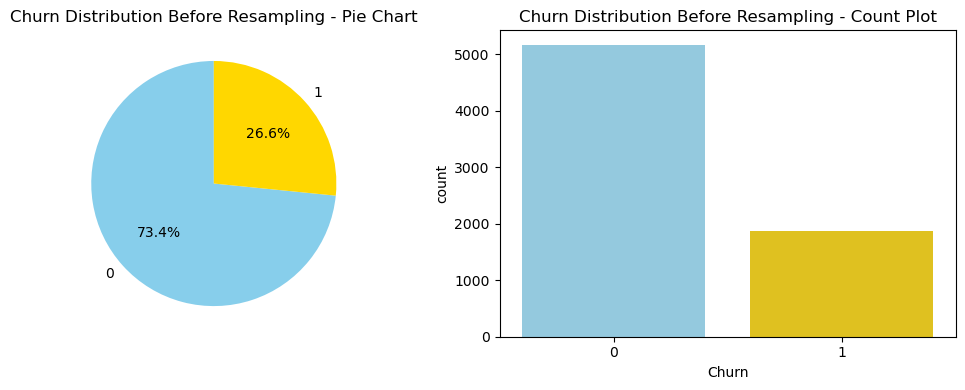

In [7]:
#set up the subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

# pie chart for the class distribution
pie_colors = ['skyblue', 'gold']
axes[0].pie(churn_df['Churn'].value_counts(), labels=churn_df['Churn'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=pie_colors)
axes[0].set_title('Churn Distribution Before Resampling - Pie Chart')

#count plot for class distribution
countplot_colors = sns.color_palette(pie_colors)
sns.countplot(x='Churn', data=churn_df, palette=countplot_colors, ax=axes[1], hue='Churn', legend=False)
axes[1].set_title('Churn Distribution Before Resampling - Count Plot')

#adjust layout
plt.tight_layout()
plt.show()

Due to the imbalance within the Churn feature, I will try resampling data in an attempt to balance the target feature, Churn.

In [8]:
#create a function to plot the class distribution after resampling
def plot_resampling_results(y_resampled, title):
    plt.figure(figsize=(4,4))
    pd.Series(y_resampled).value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=pie_colors)
    plt.title(title)
    plt.show()

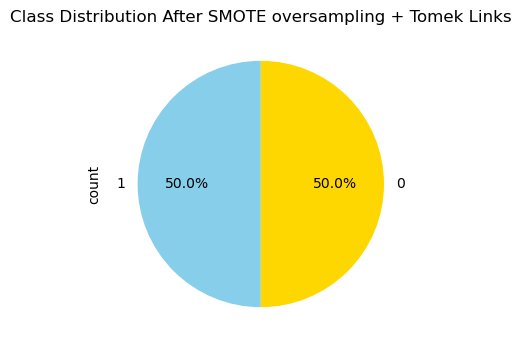

In [9]:
#Combine SMOTE and Tomek Links (note that this function applies SMOTE first and then Tomek Links)
smote_tomek = SMOTETomek()
X_train_st, y_train_st = smote_tomek.fit_resample(X_train,y_train)
plot_resampling_results(y_train_st, 'Class Distribution After SMOTE oversampling + Tomek Links')

In [10]:
#check the class distribution of target column after SMOTE oversampling + Tomek
y_train_st.value_counts()

Churn
1    3768
0    3768
Name: count, dtype: int64

In [11]:
#print the number of records added to the minority class
print("Number of records added to the minority class: ",  y_train_st.shape[0] - y_train.shape[0])


Number of records added to the minority class:  1911


In [12]:
print(X_train_st.shape, y_train_st.shape)

(7536, 51) (7536,)


As this is a classification project, we will try the following models:  RandomForest, GradientBoosting, Logistic Regression and KNearestNeighbors.  

Note that my training datasets for the records resampled through SMOTETomek are now X_train_st, y_train_st.

The original X_test and y_test data has been unchanged.

## Logistic Regression Model



In [13]:
#instantiate Logistic regression classifer
lr = LogisticRegression()

#create my param grid
params_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [50, 100]}

In [14]:
lr_grid = GridSearchCV(
    estimator= lr,
    param_grid = params_lr,
    scoring = 'accuracy',
    cv = 5,
    refit=True,
    return_train_score=True)

In [15]:
# fit our data to lr model
lr_grid.fit(X_train_st, y_train_st)

#make predictions
y_preds = lr_grid.predict(X_test)

In [16]:
# look at the best parameters and the best score
print("The best parameters for logistic regression are: ", lr_grid.best_params_)
print("Generating the best score: ", lr_grid.best_score_)

The best parameters for logistic regression are:  {'C': 1, 'max_iter': 50, 'solver': 'liblinear'}
Generating the best score:  0.8492739452845166


[[912 121]
 [158 216]]


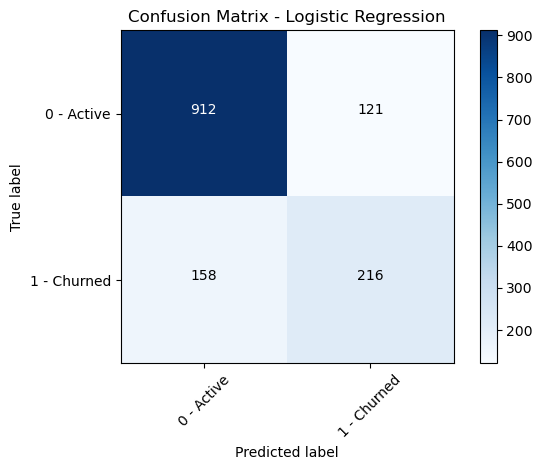

In [17]:
#plot confusion matrix for the logistic regression model
import itertools
classes = ['0 - Active', '1 - Churned']
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds)
print(cnf_matrix)

# Plot confusion matrix
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()



In [18]:
print("Classification Report for logistic regression model")
print(classification_report(y_test, y_preds))

Classification Report for logistic regression model
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1033
           1       0.64      0.58      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



Although this model did pretty well at identifying our active customers, it is still very ambiguous around the potential churn customers.  It specifically missed 158 customers
that churned, but were predicted to be active still. We will move on to Random Forest to see how it performs.

## Random Forest Model



In [19]:
#instantiate random forest classifer
rf = RandomForestClassifier()

#create my param grid
params_rf = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1,2,5]}

In [20]:
rf_grid = GridSearchCV(
    estimator= rf,
    param_grid = params_rf,
    scoring = 'accuracy',
    cv = 5,
    refit=True,
    return_train_score=True)

In [21]:
# fit our data to rf model
rf_grid.fit(X_train_st, y_train_st)

#make predictions
y_preds_rf = rf_grid.predict(X_test)

In [22]:
# look at the best parameters and the best score
print("The best parameters for random forest are: ", rf_grid.best_params_)
print("Generating the best score: ", rf_grid.best_score_)

The best parameters for random forest are:  {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 50}
Generating the best score:  0.8674494269888179


[[886 147]
 [158 216]]


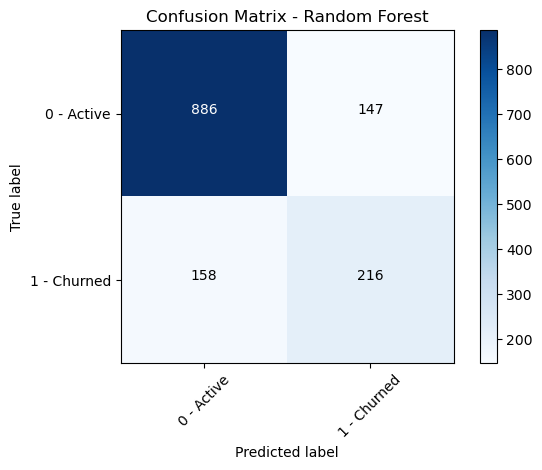

In [23]:
#plot confusion matrix for the random forest model
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds_rf)
print(cnf_matrix)

# Plot confusion matrix
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [24]:
print("Classification Report for random forest model")
print(classification_report(y_test, y_preds_rf))

Classification Report for random forest model
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1033
           1       0.60      0.58      0.59       374

    accuracy                           0.78      1407
   macro avg       0.72      0.72      0.72      1407
weighted avg       0.78      0.78      0.78      1407



The random forest model's performance was only marginally lower than the logistic regression model.  Next, we will try the gradientboosting classification model.

## GradientBoosting Model



In [25]:
#instantiate gradient boosting classifer
gb = GradientBoostingClassifier()

#create my param grid
params_gb = {
    'n_estimators': [25, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5],
    'max_features': [2,5,10,15]}

In [26]:
gb_grid = GridSearchCV(
    estimator= gb,
    param_grid = params_gb,
    scoring = 'accuracy',
    cv = 5,
    refit=True,
    return_train_score=True)

In [27]:
# fit our data to gb model
gb_grid.fit(X_train_st, y_train_st)

#make predictions
y_preds_gb = gb_grid.predict(X_test)

In [28]:
# look at the best parameters and the best score
print("The best parameters for gradient boosting are: ", gb_grid.best_params_)
print("Generating the best score: ", gb_grid.best_score_)

The best parameters for gradient boosting are:  {'learning_rate': 0.1, 'max_features': 5, 'n_estimators': 200}
Generating the best score:  0.858959251169168


[[893 140]
 [149 225]]


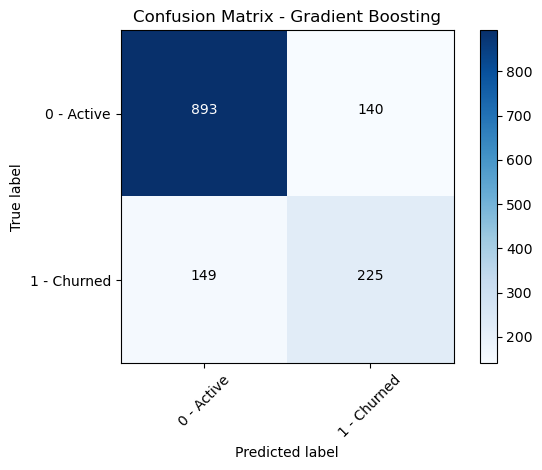

In [29]:
#plot confusion matrix for the gradient boosting model
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds_gb)
print(cnf_matrix)

# Plot confusion matrix
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Gradient Boosting')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [30]:
print("Classification Report for gradient boosting model")
print(classification_report(y_test, y_preds_gb))

Classification Report for gradient boosting model
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1033
           1       0.62      0.60      0.61       374

    accuracy                           0.79      1407
   macro avg       0.74      0.73      0.73      1407
weighted avg       0.79      0.79      0.79      1407



After 3 models, it would still appear that the best is the logistic regression model.  It's score is inline with the rest, but is computationally less expensive than
the other models.  We will try one more model, KNearestNeighbor.

## KNearest Neighbor Model



In [31]:
#instantiate KNN classifer
knn = KNeighborsClassifier()

#create my param grid
params_knn = {
    'n_neighbors': [3, 5, 7, 11, 15, 27],
    'weights': ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}


In [32]:
knn_grid = GridSearchCV(
    estimator= knn,
    param_grid = params_knn,
    scoring = 'accuracy',
    cv = 5,
    refit=True,
    return_train_score=True)

In [33]:
# fit our data to KNN model
knn_grid.fit(X_train_st, y_train_st)

#make predictions
y_preds_knn = knn_grid.predict(X_test)

In [34]:
# look at the best parameters and the best score
print("The best parameters for KNN are: ", knn_grid.best_params_)
print("Generating the best score: ", knn_grid.best_score_)

The best parameters for KNN are:  {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Generating the best score:  0.8349286002193125


[[745 288]
 [144 230]]


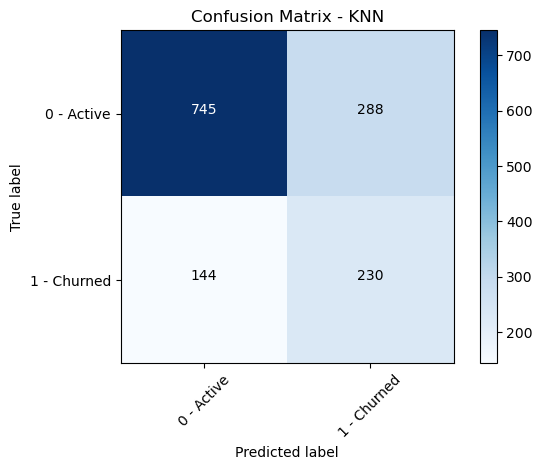

In [35]:
#plot confusion matrix for the KNN model
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_preds_knn)
print(cnf_matrix)

# Plot confusion matrix
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - KNN')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [36]:
print("Classification Report for KNN model")
print(classification_report(y_test, y_preds_knn))

Classification Report for KNN model
              precision    recall  f1-score   support

           0       0.84      0.72      0.78      1033
           1       0.44      0.61      0.52       374

    accuracy                           0.69      1407
   macro avg       0.64      0.67      0.65      1407
weighted avg       0.73      0.69      0.71      1407



Conclusion:  Out of the four models attempted, all of the scores were very similar.  However, the one that slightly edges out the rest is the logistic regression model, given that it
is computationally less expensive than the other models.  However, I would most likely try additional preprocessing steps to see how they impact the model.  For example, trying the models leveraging a MinMaxScaler vs StandardScaler.  I would also potentially try running the models again, using a different resampling method, perhaps Random Over sampling, or ADASYN.  To see if I could boost the f1 scores for the Churn predictor.